In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import requests
from tqdm import tqdm
import os
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader


In [ ]:
#plots for loss and accuracy

sns.set_style('whitegrid')
plt.rcParams.update({'font.size':15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1,2,figsize = (13,4))
    axs[0].plot(range(1, len(train_losses)+1), train_losses, label = 'train')
    axs[0].plot(range(1, len(test_losses)+1), test_losses, label = 'test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies)+1), train_accuracies, label = 'train')
    axs[1].plot(range(1, len(test_accuracies)+1), test_accuracies, label = 'test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [ ]:
def training_epoch(model, oprimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        oprimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)


        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(model, optimizer, criterion, train_loader, tqdm_desc = f'Training {epoch}/{num_epochs}')
        test_loss, test_accuracy = validation_epoch(model, criterion, test_loader, tqdm_desc = f'Validation {epoch}/{num_epochs}')


        if scheduler is not None:
            scheduler.step()


        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
!ls /content/drive/MyDrive/mushrooms/mushroomData


'Amanita muscaria'	  Flammulina		 'Inonotus obliquus'	    'Sarcoscypha austriaca'
'Boletus edulis'	 'Fomes fomentarius'	 'Laetiporus sulphureus'    'Vulpicida pinastri'
'Cantharellus cibarius'  'Fomitopsis betulina'	 'Leccinum scabrum'	    'Xanthoria parietina'
'Cetraria islandica'	 'Fomitopsis pinicola'	 'Parmelia sulcata'
'Coprinus comatus'	 'Ganoderma applanatum'  'Platismatia glauca'
'Evernia prunastri'	 'Hypogymnia physodes'	 'Pseudevernia furfuracea'


In [ ]:
# custom dataset class

class MushroomDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25
# path to root directory
    def __init__(self, root='/content/drive/MyDrive/mushrooms/mushroomData', train=True, load_to_ram=False, transform=None):
        super(MushroomDataset, self).__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.all_files = []
        self.all_labels = []
        self.images = []

        # sorted list of all classes
        self.classes = sorted(os.listdir(self.root))


        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root, class_name)
            files = sorted(os.listdir(class_dir))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i, test_size=self.TEST_SIZE)


            selected_files = train_files if self.train else test_files
            self.all_files += [os.path.join(class_name, f) for f in selected_files]
            self.all_labels += [i] * len(selected_files)


            if self.load_to_ram:
                self.images += [Image.open(os.path.join(class_dir, f)).convert('RGB') for f in selected_files]

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        label = self.all_labels[idx]
        if self.load_to_ram:
            image = self.images[idx]
        else:
            image_path = os.path.join(self.root, self.all_files[idx])
            image = Image.open(image_path).convert('RGB')


        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_dataset = MushroomDataset(root = '/content/drive/MyDrive/mushrooms/mushroomData', train=True)

In [ ]:
image, label = train_dataset[4080]
label

20

In [ ]:
normalize = T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])


train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [ ]:
train_dataset = MushroomDataset(root = '/content/drive/MyDrive/mushrooms/mushroomData', train=True, load_to_ram=False, transform=train_transform)
test_dataset = MushroomDataset(root = '/content/drive/MyDrive/mushrooms/mushroomData', train=False, load_to_ram=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 118MB/s]


In [ ]:
num_epochs = 20

In [ ]:
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

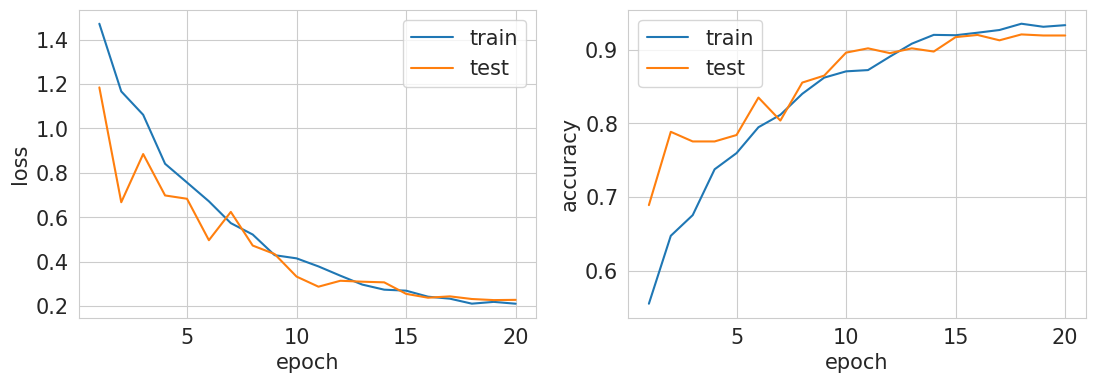

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:

torch.save(model, '/content/drive/MyDrive/mushrooms/model_mushrooms_mobilenet.pth')


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/mushrooms/model_mushrooms_mobilenet_weights.pth')


In [ ]:
# just photo for test
image = Image.open('/content/drive/MyDrive/mushrooms/lisichka.jpg')

In [ ]:
# preprocessing before inference

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Lambda(lambda x: x[:3, :, :]), # if there's alpha
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image = transform(image).unsqueeze(0)
image = image.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
print("Predicted class:", predicted.item())


In [ ]:
mushroom_labels = {
    0: 'Amanita muscaria',
    1: 'Boletus edulis',
    2: 'Cantharellus cibarius',
    3: 'Cetraria islandica',
    4: 'Coprinus comatus',
    5: 'Evernia prunastri',
    6: 'Flammulina',
    7: 'Fomes fomentarius',
    8: 'Fomitopsis betulina',
    9: 'Fomitopsis pinicola',
    10: 'Ganoderma applanatum',
    11: 'Hypogymnia physodes',
    12: 'Inonotus obliquus',
    13: 'Laetiporus sulphureus',
    14: 'Leccinum scabrum',
    15: 'Parmelia sulcata',
    16: 'Platismatia glauca',
    17: 'Pseudevernia furfuracea',
    18: 'Sarcoscypha austriaca',
    19: 'Vulpicida pinastri',
    20: 'Xanthoria parietina'
}

In [ ]:
print(mushroom_labels[predicted.item()])